In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from data.io import Reader, Saver
from analyzer.model.regression_model import RegressionModel
from data.plot import Drawer
from analyzer.stat_criterion.stat_criteria import StatCriteria
from data.encoder import Encoder
from data.normalizer import Normalizer
from data import DataPreparation

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import kruskal, mannwhitneyu, chi2_contingency, chisquare, norm, ttest_1samp, ttest_ind, shapiro



In [31]:
# читаем датасет
csv_path = Reader.get_csv_path('notebooks\dataset', 'RK_554B_data.csv')
df_original = Reader.read_csv(csv_path)
df = df_original.copy().reset_index(drop=True)
df = df.drop('number', axis = 1)
df = df.replace(r'\*', '', regex=True)
df.head(10)

,freq,r,c0,cq,q1000,tmax,rc/rb,resistor
0,-0.6,72.3,2.89,0.19,1163,82.3,1.22,8449
1,0.3,66.2,2.76,0.20,1220,83.2,1.38,8497
2,-0.4,65.8,2.91,0.20,1232,83.8,1.42,7326
3,-0.9,73.6,2.86,0.18,1192,84.3,1.23,8899
4,0.5,68.0,2.92,0.19,1200,80.4,1.38,9116
5,0.0,65.6,2.97,0.20,1227,83.9,1.43,8186
6,0.2,72.1,2.95,0.19,1143,85.4,1.37,7107
7,0.2,74.7,2.72,0.18,1164,80.8,1.63,9709
8,1.3,69.9,2.91,0.20,1138,86.9,1.41,7182
9,-1.3,66.8,2.83,0.20,1184,81.9,1.47,8379


# Постановка задачи

найти значение compensation_resistor на основе использования поступающих входных данных

# Преобразование данных

In [32]:
# посмотрим на пропуски в данных
df.isna().sum()

freq        0
r           0
c0          0
cq          0
q1000       0
tmax        0
rc/rb       0
resistor    0
dtype: int64

In [33]:
# смотрим на типы данных и требования к памяти
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   freq      184 non-null    float64
 1   r         184 non-null    float64
 2   c0        184 non-null    float64
 3   cq        184 non-null    float64
 4   q1000     184 non-null    int64  
 5   tmax      184 non-null    float64
 6   rc/rb     184 non-null    float64
 7   resistor  184 non-null    object 
dtypes: float64(6), int64(1), object(1)
memory usage: 11.6+ KB


In [34]:
# Посмотрим статистику о датасете
df.describe()

,freq,r,c0,cq,q1000,tmax,rc/rb
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,-0.243478,69.123913,2.830272,0.190163,1204.875000,83.725000,1.373098
std,1.082731,4.406611,0.156035,0.007050,64.024505,3.053409,0.063312
min,-7.800000,63.100000,1.010000,0.150000,867.000000,76.500000,1.110000
25%,-0.600000,66.275000,2.800000,0.190000,1176.750000,81.600000,1.350000
50%,-0.100000,68.050000,2.840000,0.190000,1208.000000,83.800000,1.380000
75%,0.400000,70.950000,2.890000,0.190000,1241.250000,85.525000,1.410000
max,4.600000,98.100000,3.210000,0.200000,1368.000000,94.600000,1.630000


# Проводим визуальный анализ

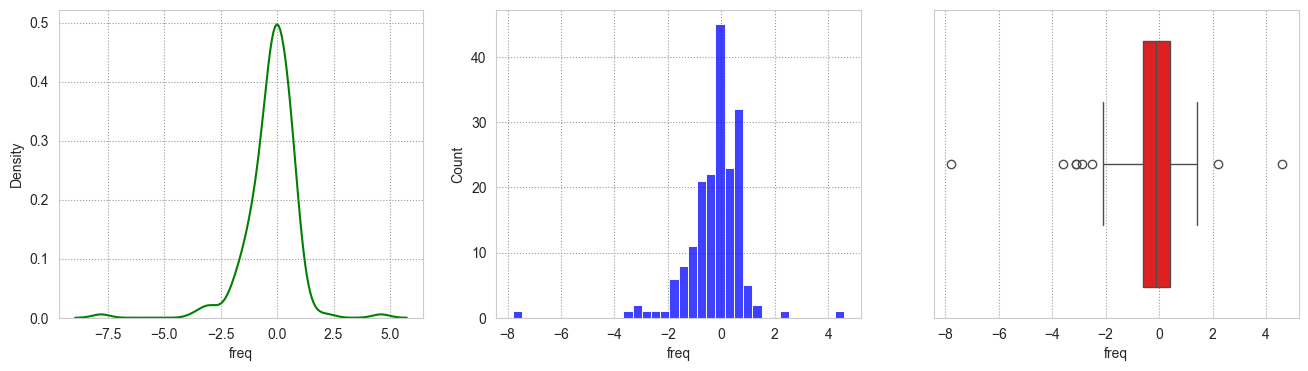

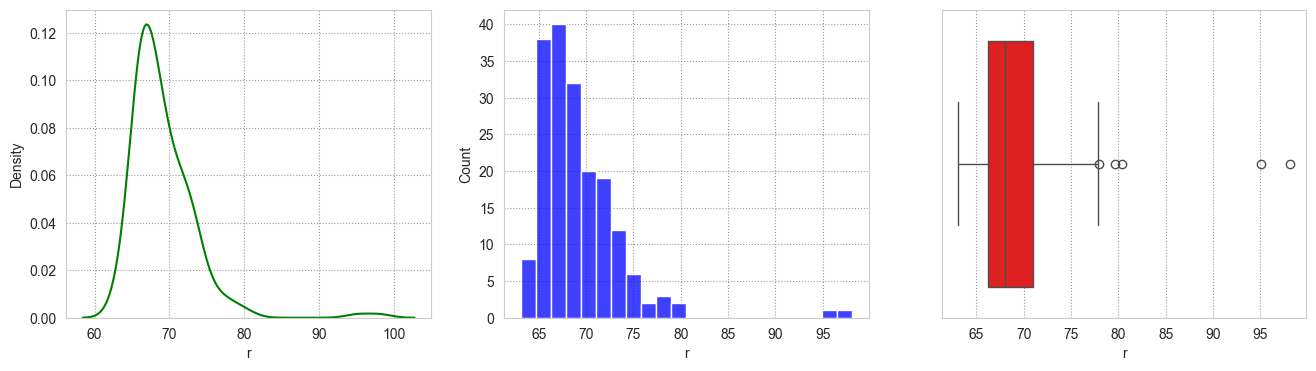

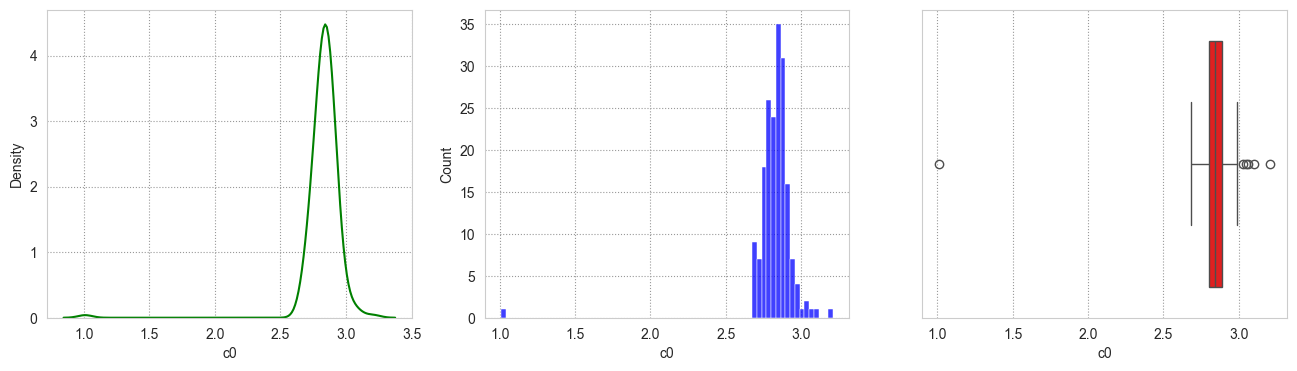

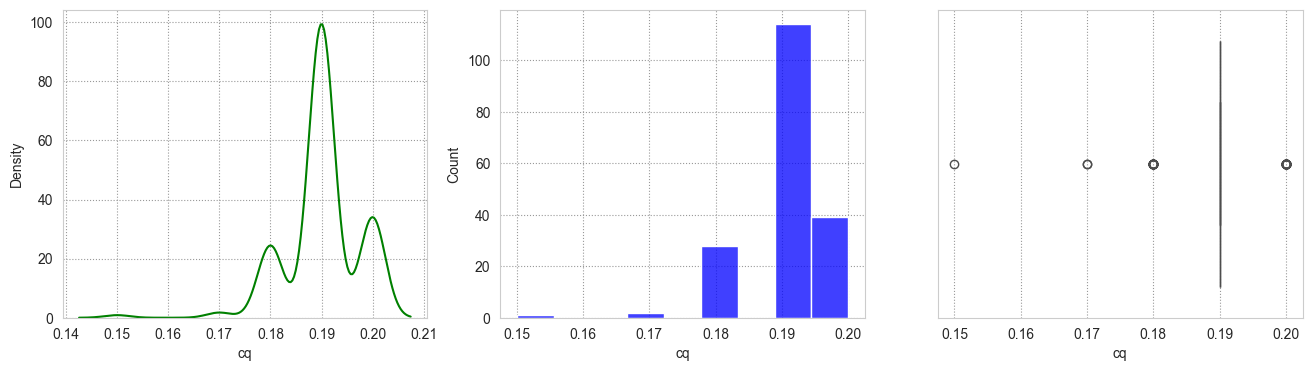

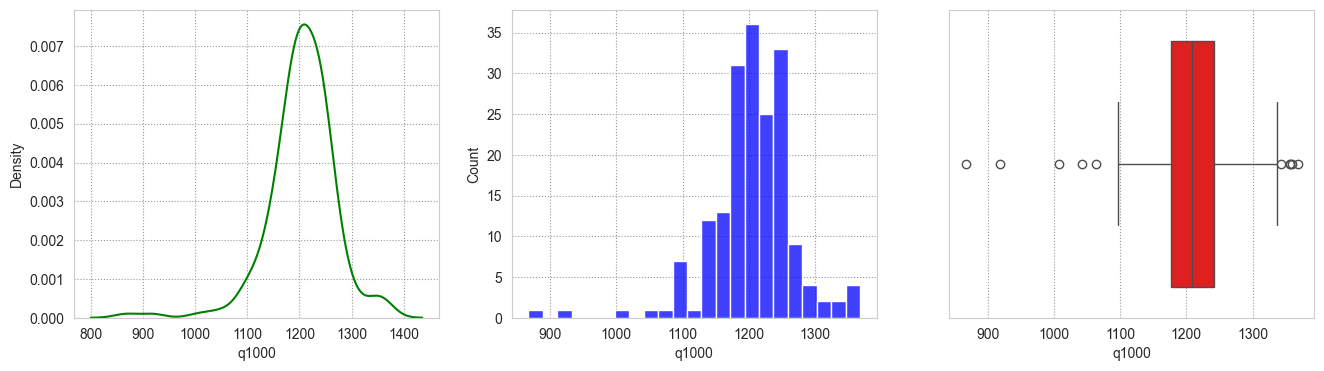

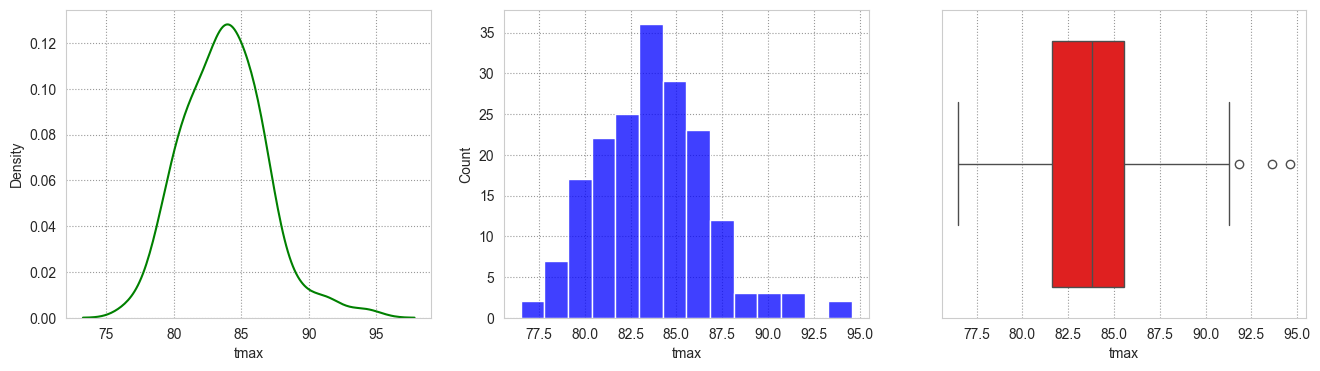

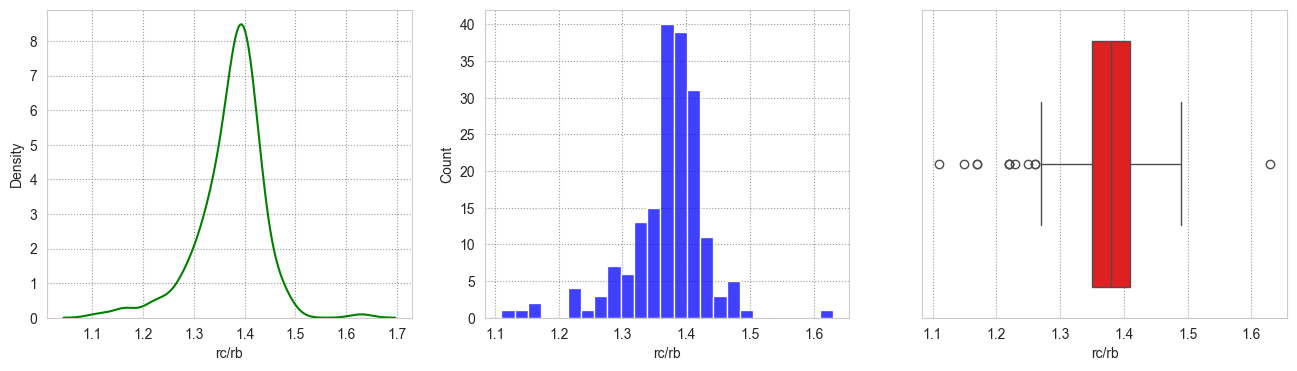

In [35]:
# Посмотрим на виды распределений "числовых" параметров и на ящики с усами
Drawer.plot_numeric_seaborn(df)

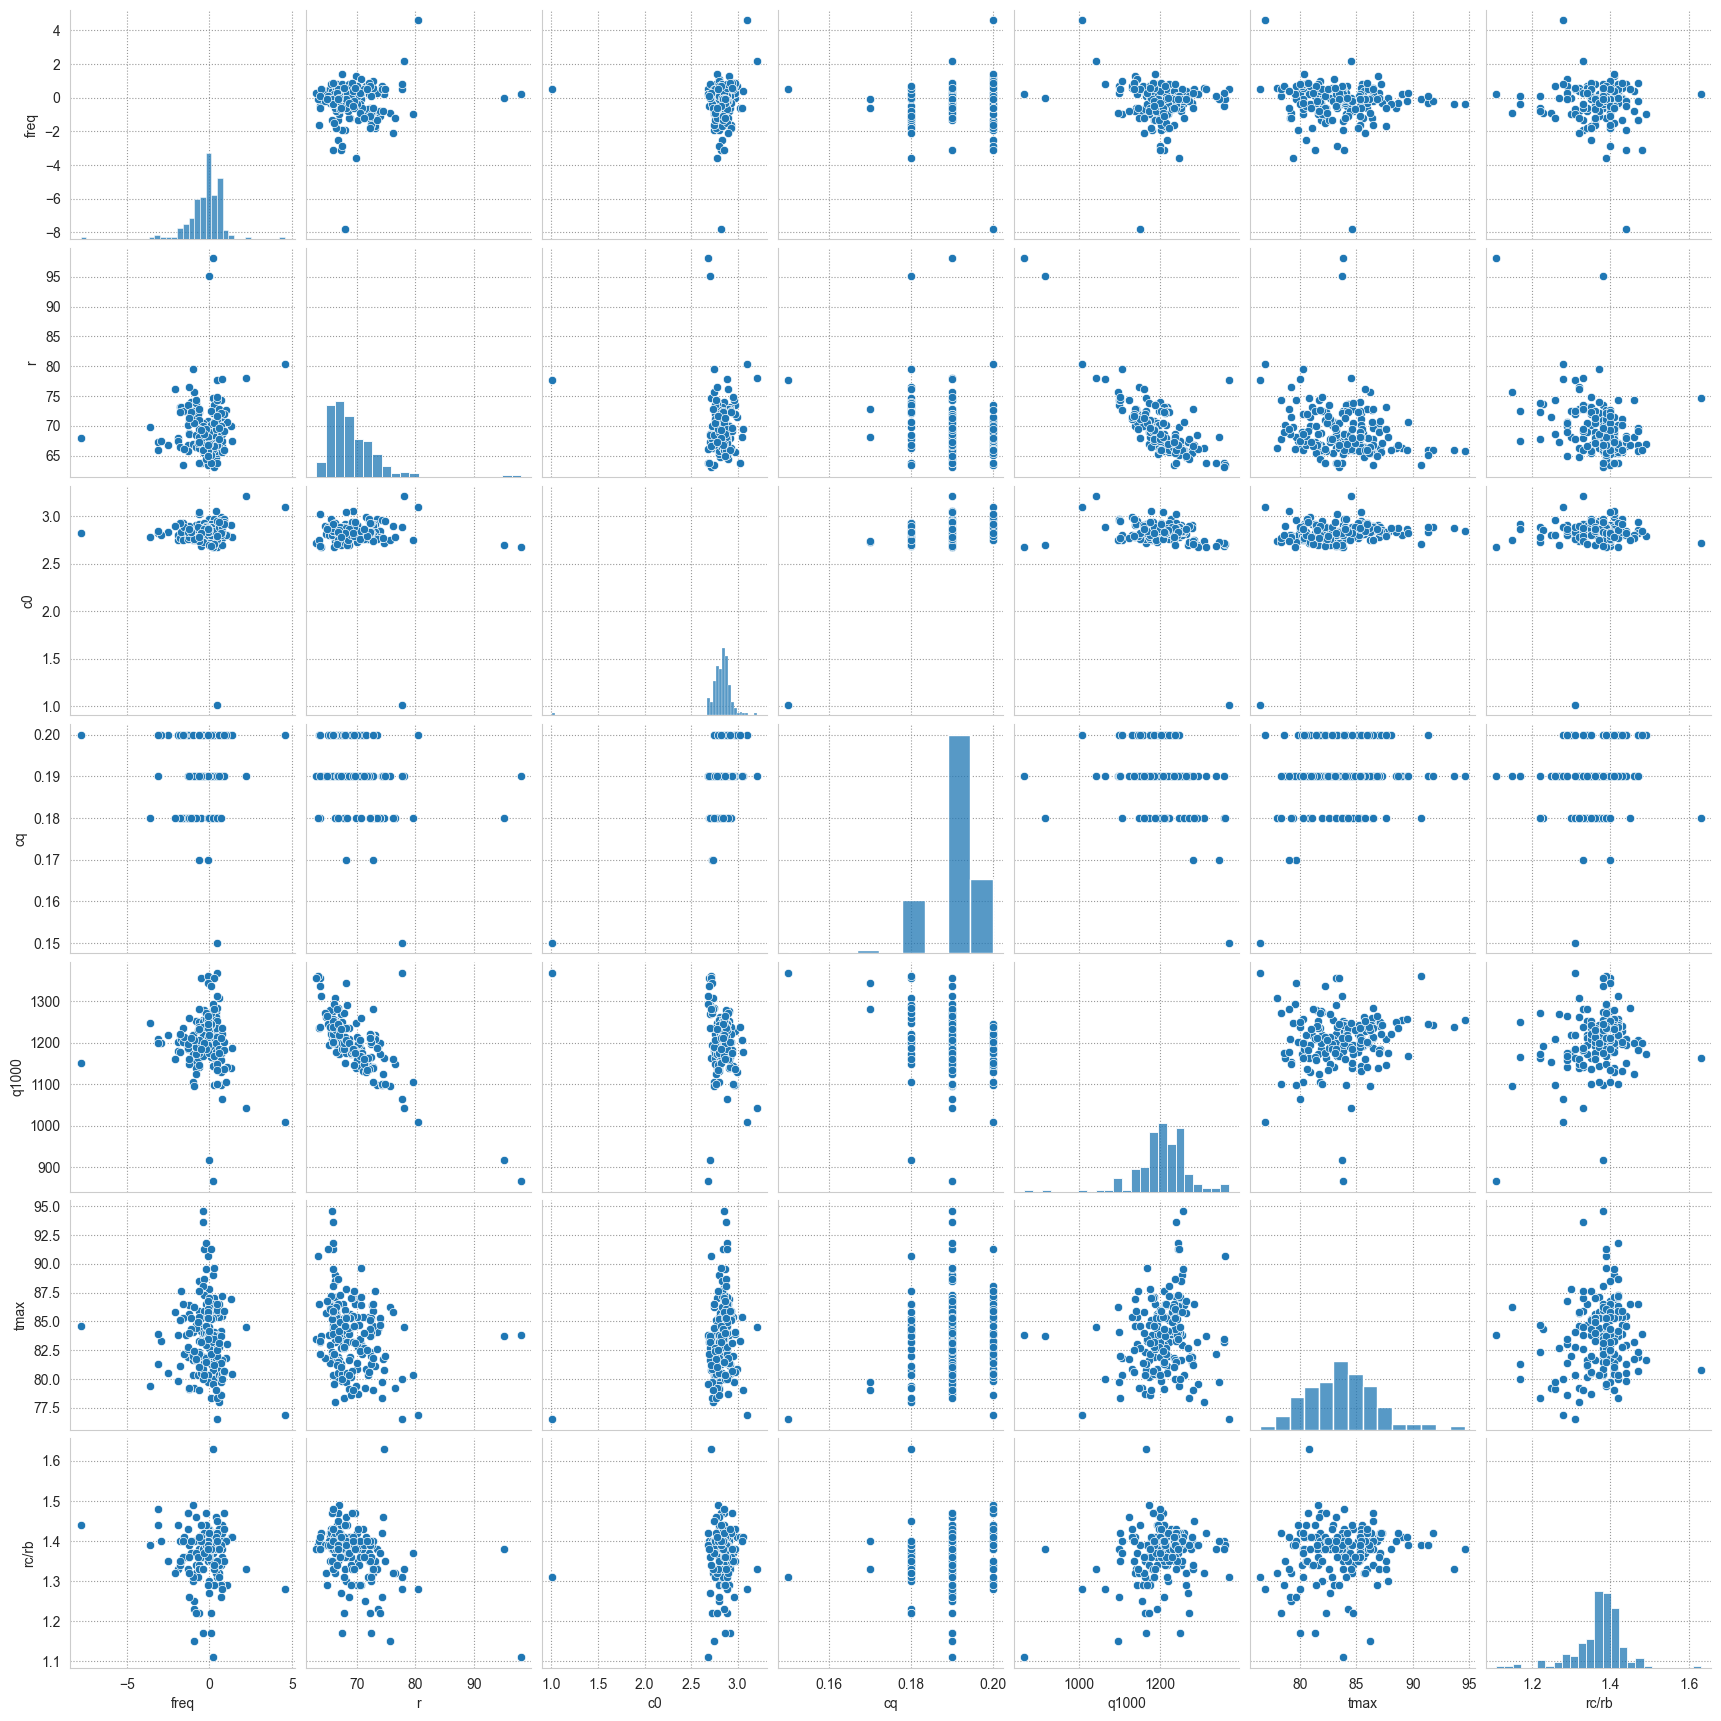

In [36]:
# Исследуем графически зависимость признаков на целевую переменную для обычной недвижимости
numeric_col = df.describe().columns
sns.pairplot(df[numeric_col])

# Анализ зависимости признаков

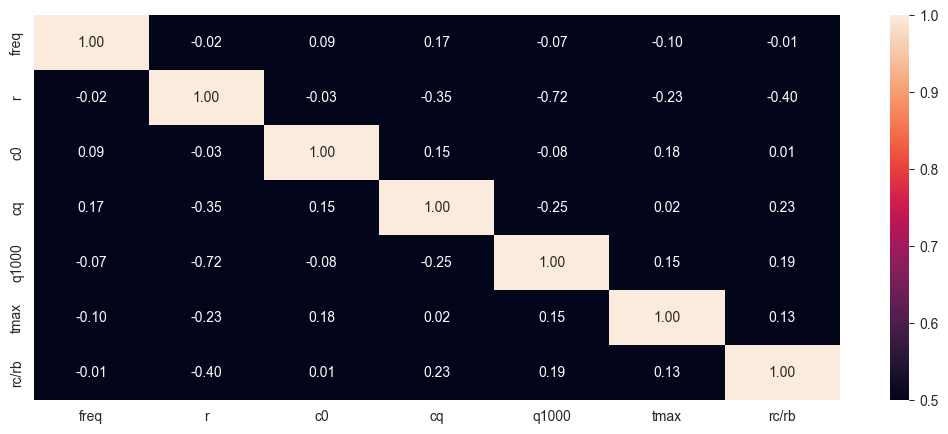

In [37]:
# Исследуем тепловую карту корреляции признаков на целевую переменную для обычной недвижимости
plt.figure(figsize=(13,5))
sns.heatmap(df.corr(method='spearman', numeric_only=True), annot=True, fmt='.2f', vmin=0.5)
plt.show()

In [38]:
df.columns

Index(['freq', 'r', 'c0', 'cq', 'q1000', 'tmax', 'rc/rb', 'resistor'], dtype='object')

In [39]:
# Проверим допущение о мультиколлинеарности
columns_list = ['resistor']
numeric_col = df.drop(columns=columns_list).describe().columns
vif_data = pd.DataFrame()
vif_data.index = numeric_col

vif_data['VIF'] = [variance_inflation_factor(df[numeric_col].values, i) for i in range(len(numeric_col))]
vif_data

,VIF
freq,1.075265
r,182.170186
c0,439.232811
cq,766.511178
q1000,381.719763
tmax,811.919873
rc/rb,538.007523


In [40]:
df.head()

,freq,r,c0,cq,q1000,tmax,rc/rb,resistor
0,-0.6,72.3,2.89,0.19,1163,82.3,1.22,8449
1,0.3,66.2,2.76,0.20,1220,83.2,1.38,8497
2,-0.4,65.8,2.91,0.20,1232,83.8,1.42,7326
3,-0.9,73.6,2.86,0.18,1192,84.3,1.23,8899
4,0.5,68.0,2.92,0.19,1200,80.4,1.38,9116


In [41]:
groups = [df['extremum'], df['compensation_resistor']]
stat, p_value = mannwhitneyu(*groups, alternative='two-sided')
print(p_value)

KeyError: 'extremum'

In [31]:
groups = [df['frequency_stability'], df['compensation_resistor']]
stat, p_value = mannwhitneyu(*groups, alternative='two-sided')
print(p_value)

6.428288313133261e-10


In [32]:
groups = [df['frequency_stability'], df['extremum']]
stat, p_value = mannwhitneyu(*groups, alternative='two-sided')
print(p_value)

6.460612699116543e-10


# Подготавливаем данные

In [33]:
# подготавливаем данные
target = ['compensation_resistor']
exclude_features = ['compensation_resistor', 'temperature_of_peregib']
# exclude_features = ['compensation_resistor', 'temperature_of_peregib', 'frequency_stability']

X_train, X_test, y_train, y_test = DataPreparation().split_data(df, exclude_features, target)

# проводим нормализацию
X_train, X_test, y_train, y_test = Normalizer().min_max_scaling(X_train, X_test, y_train, y_test)

# Создаём модель

In [34]:
# Применим метод опорных векторов
y_test, y_pred = RegressionModel().SVR(X_train, X_test, y_train, y_test, kernel='rbf', C=1.0, epsilon=0.1)

R²: -0.934
MAE: 0.23
MAPE: 30%
RMSE: 0
MSE: 0


C:\Users\Tikhon\Documents\PycharmProjects\KVGresistor\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
